In [1]:
import ast
import pandas as pd 
import glob
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
from sklearn.metrics import silhouette_score
from dotenv import load_dotenv
import seaborn as sns
from usflc_xai import models, datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import gc
import numpy as np
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from joblib import Parallel, delayed
load_dotenv()

CROP_IMAGE_DIR = os.getenv('CROP_IMAGE_DIR_PATH')
test_data_id = '09'
metadata_name = 'meta_data/TWB_ABD_expand_modified_gasex_21072022.csv'
test_data_list_name = 'fattyliver_2_class_certained_0_123_4_20_40_dataset_lists/dataset'+str(test_data_id)+'/test_dataset'+str(test_data_id)+'.csv'
test_data_list = pd.read_csv(test_data_list_name)
meta_data = pd.read_csv(metadata_name, sep=",")

image_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckpt_name = 'model_tl_twbabd'+str(test_data_id)+'/best_results.ckpt'
image_encoder_id = 'densenet121'
graph_encoder_id = 'SETNET_GAT'
num_classes = 2
input_dim = 1024
num_layers = 1
transform = transforms.Compose([
transforms.Grayscale(num_output_channels=3),
transforms.Resize([224, 224]),
transforms.ToTensor(),
transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

## Call pretrained image encoder ###
_, pretrained_image_encoder = models.image_encoder_model(name=image_encoder_id, 
                                        pretrained=True, 
                                        num_classes=num_classes, 
                                        device=device)
pretrained_image_encoder = pretrained_image_encoder.eval() 


## Subject id in the test data ##
mi_id = test_data_list['MI_ID'][0]
mi_id = "P0012750"
## Obtain image ids and label y for each subject. ###
img_id_list = ast.literal_eval(meta_data[meta_data['MI_ID']==mi_id]['IMG_ID_LIST'].to_list()[0])
print(mi_id, len(img_id_list), img_id_list)
y = 1

P0012750 25 ['IMG0001', 'IMG0002', 'IMG0003', 'IMG0004', 'IMG0005', 'IMG0006', 'IMG0007', 'IMG0008', 'IMG0009', 'IMG0010', 'IMG0011', 'IMG0013', 'IMG0014', 'IMG0016', 'IMG0018', 'IMG0021', 'IMG0022', 'IMG0023', 'IMG0024', 'IMG0025', 'IMG0026', 'IMG0027', 'IMG0029', 'IMG0030', 'IMG0032']


In [2]:
ground_truth_pos_mi_ids = [mi_id
         for mi_id in test_data_list['MI_ID'] 
         if meta_data[meta_data['MI_ID']==mi_id]['liver_fatty'].to_list()[0]  > 0 ]
selected_mi_ids = [mi_id for mi_id in ground_truth_pos_mi_ids
                   if len(ast.literal_eval(meta_data[meta_data['MI_ID']==mi_id]['IMG_ID_LIST'].to_list()[0])) > 20
                   ]
selected_mi_ids = list(set(selected_mi_ids))
print(len(ground_truth_pos_mi_ids), len(selected_mi_ids))

445 98


In [3]:
img_id_list = ast.literal_eval(meta_data[meta_data['MI_ID']==mi_id]['IMG_ID_LIST'].to_list()[0])
img_abs_filepaths = [CROP_IMAGE_DIR + str(mi_id) +'_'+str(i)+'.jpg' for i in img_id_list]
assert(len(img_abs_filepaths) == len(img_id_list))
assert(all(os.path.exists(i) for i in img_abs_filepaths))

In [4]:
from classifiers import GLMNET_ElasticNetClassifierWithStats

def select_unique_columns(df):
    # Transpose the dataframe to compare columns
    df_t = df.T

    # Drop duplicate rows (which were originally columns)
    df_unique = df_t.drop_duplicates()
    
    # Transpose back to original orientation
    return df_unique.T

  0%|          | 0/3 [00:00<?, ?it/s]/home/tjyen/anaconda3/envs/xai/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
 33%|███▎      | 1/3 [00:00<00:00,  6.85it/s]

Only one class present in y_true. ROC AUC score is not defined in that case.
P0010354 was skipped because ElasticNet is having some issues


/home/tjyen/anaconda3/envs/xai/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
 67%|██████▋   | 2/3 [00:01<00:00,  1.45it/s]

Only one class present in y_true. ROC AUC score is not defined in that case.
P0007335 was skipped because ElasticNet is having some issues


100%|██████████| 100/100 [03:34<00:00,  2.14s/it]


Best ROC-AUC: 1.0
Accuracy from best alpha: 1.0
Refitting model with best alpha 0.01
Best alpha value:  0.01
Best lambda value:  0.0014261520224067741
Intercept value:  -0.8705486166244407
Boostrapping...


100%|██████████| 100/100 [00:00<00:00, 469161.52it/s]

Could not save alphas_vs_weights.png because /home/liuusa_tw/twbabd_image_xai_20062024/custom_lime_results/elastic-net-07-31-2024-09-21-45/P0003323 is not a valid path


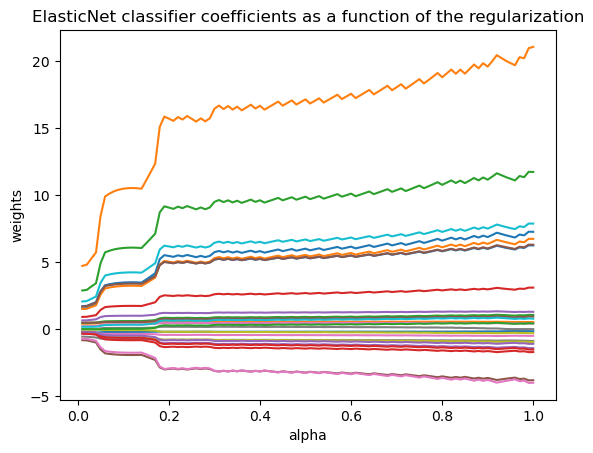

AUC on holdout test set 1.0 for P0003323


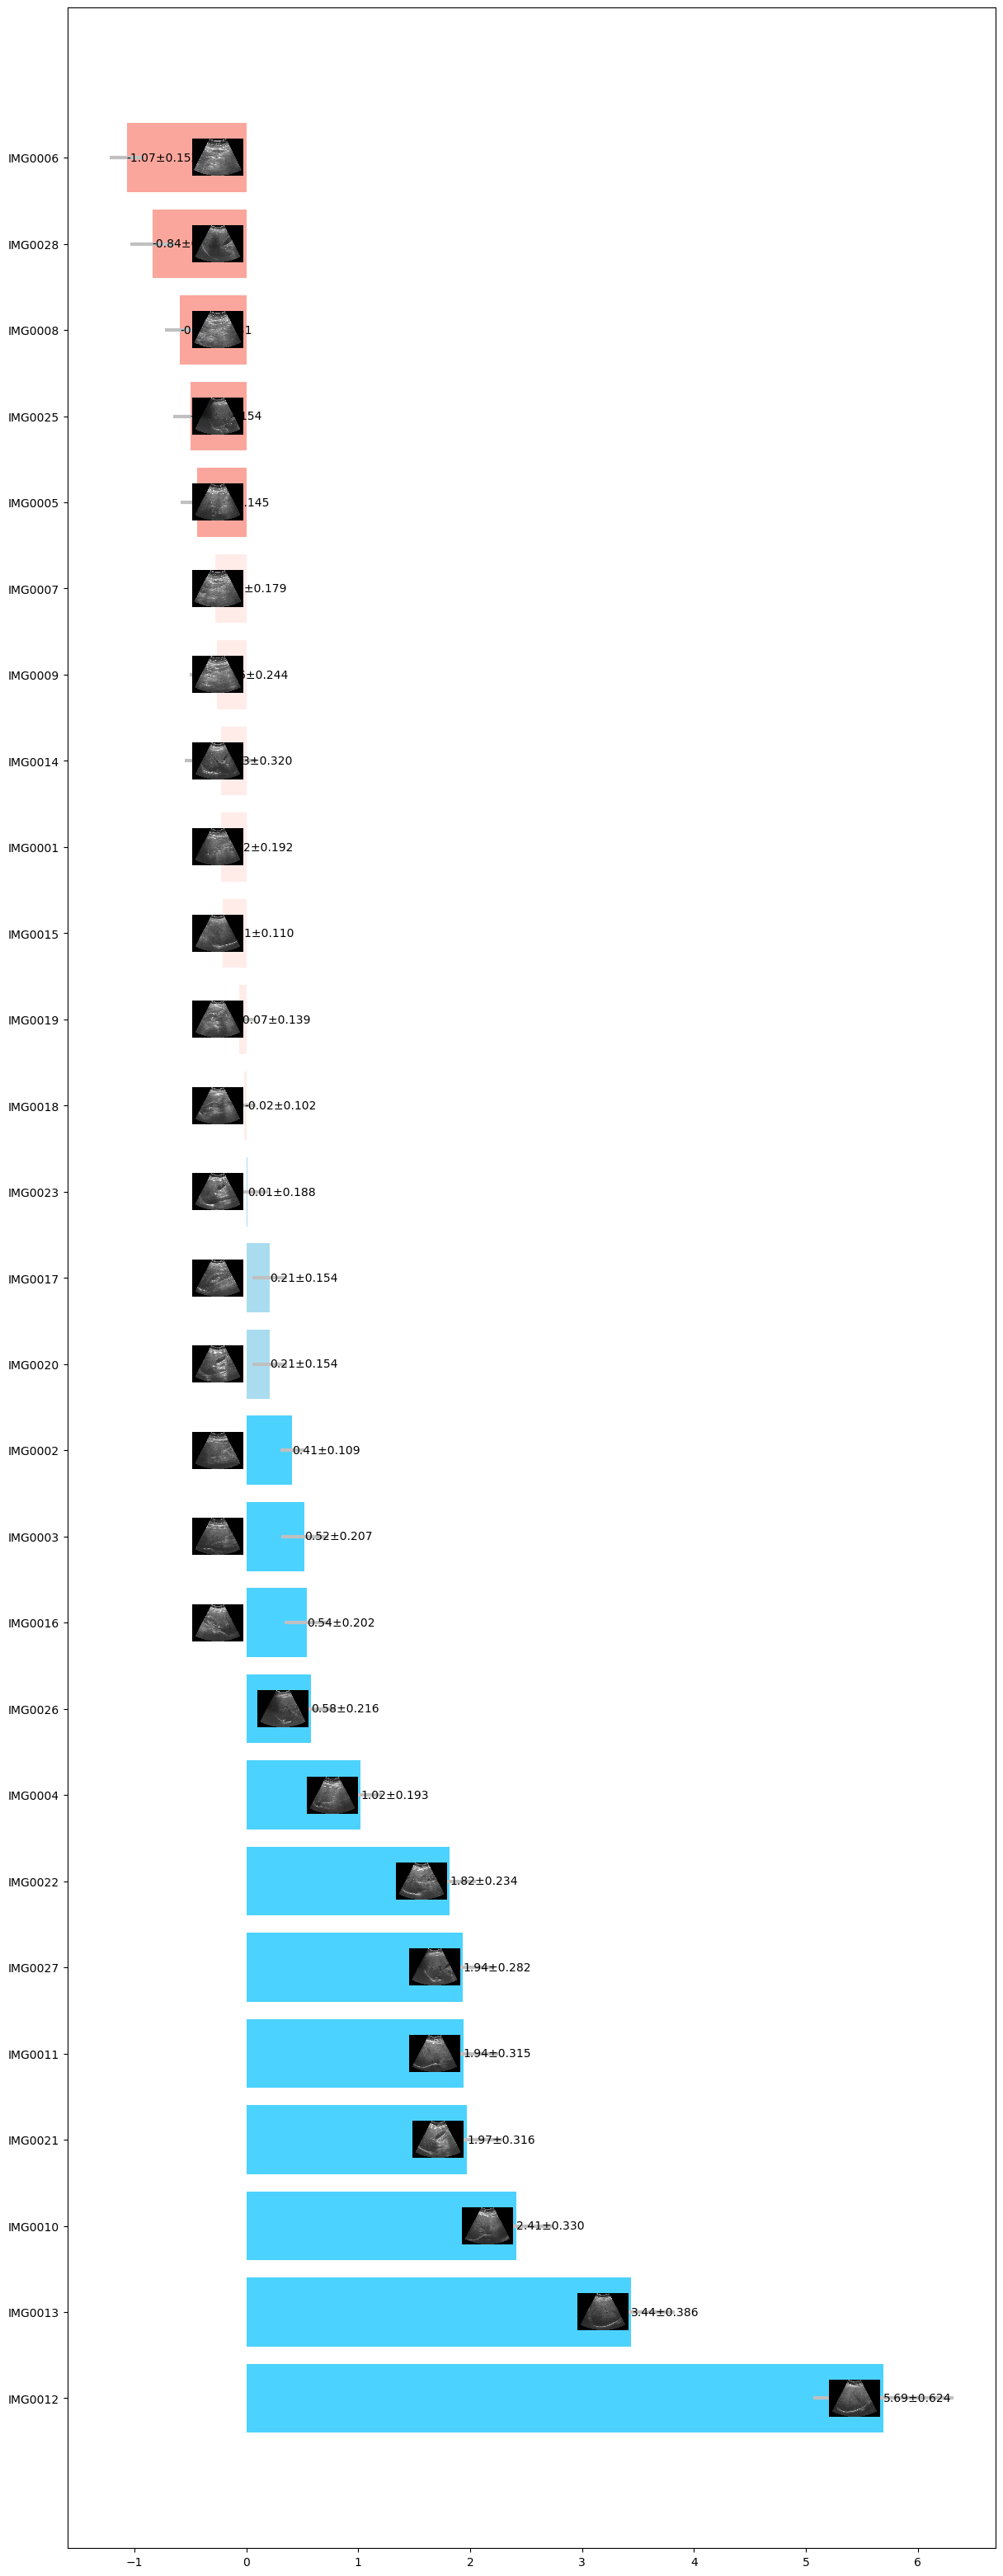

<Figure size 640x480 with 0 Axes>

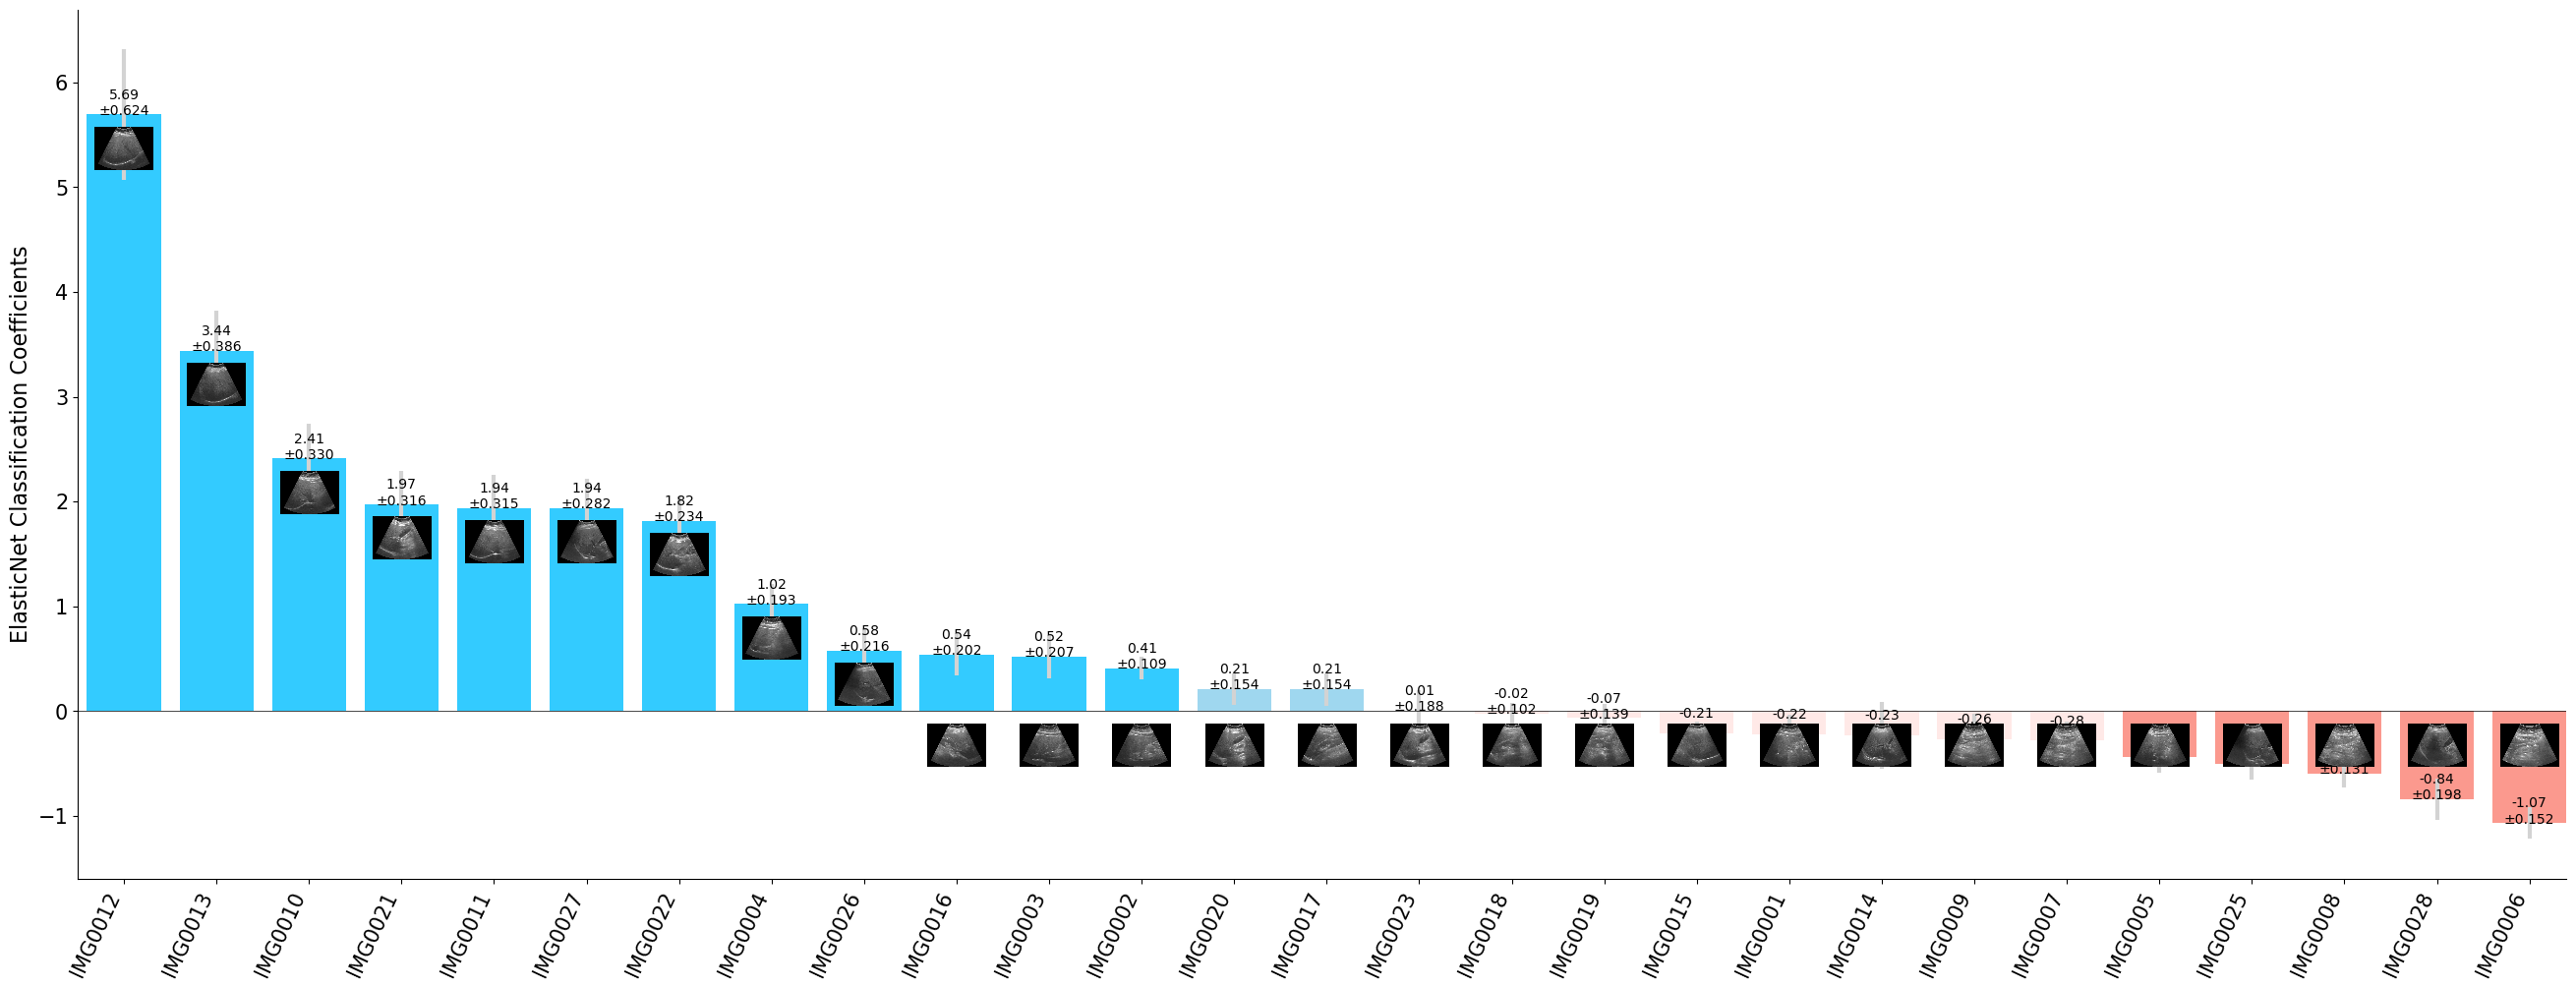

100%|██████████| 3/3 [04:25<00:00, 88.36s/it] 

Results saved to /home/liuusa_tw/twbabd_image_xai_20062024/custom_lime_results/elastic-net-07-31-2024-09-22-19


<Figure size 640x480 with 0 Axes>

In [6]:
import datetime 
result_dir = "/home/liuusa_tw/twbabd_image_xai_20062024/custom_lime_results/07-12-2024-03-57-58/"
current_timestamp = datetime.datetime.now().strftime('%m-%d-%Y-%H-%M-%S')
all_subj_save_dir = os.path.join("/home/liuusa_tw/twbabd_image_xai_20062024/custom_lime_results",f"elastic-net-old-dataset-{current_timestamp}")
os.mkdir(all_subj_save_dir)
if result_dir.endswith("/"):
    csv_paths = glob.glob(result_dir+ "*/pred_results.csv")
else:
    csv_paths = glob.glob(result_dir+ "/*/pred_results.csv")
    
csv_paths = csv_paths[:3]

mi_ids = [i.split("/pred_results.csv")[0].split("/")[-1] for i in csv_paths]
df_dict = {mi_ids[i]: csv_paths[i] for i, _ in enumerate(mi_ids)}
df_dict = {k: pd.read_csv(v) for k, v in df_dict.items()}
df_dict = {k: v.drop_duplicates() for k, v in df_dict.items()}

miid_imgid_dict = {mi_id: ast.literal_eval(meta_data[meta_data['MI_ID']==mi_id]['IMG_ID_LIST'].to_list()[0]) 
                   for mi_id in mi_ids}

n_bootstrap_iterations = 10000

# img_abs_filepaths = {id: CROP_IMAGE_DIR + str(mi_id) +'_'+str(id)+'.jpg' for id in img_id_list}
# assert(len(img_abs_filepaths) == len(img_id_list))
# assert(all(os.path.exists(i) for i in img_abs_filepaths))
# print(img_id_list)

for i, (mi_id, df) in tqdm(enumerate(df_dict.items()), total = len(df_dict.keys())):
    if len(df['yhat'].unique()) < 2:
        print(f"{mi_id} was skipped because all y_hat were the same_values")
        continue
    
    # img_ids = miid_imgid_dict.get(mi_id)
    
    X_df = df.drop(['yhat', 'y'], axis=1).copy()
    X_df = select_unique_columns(X_df)
    y_df = df[['yhat']].copy()
    X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, 
                                                        stratify=y_df,
                                                        test_size=0.05, random_state=42)
    y_train, y_test = y_train.to_numpy().ravel(), y_test.to_numpy().ravel()

    img_filepaths = [os.path.join(CROP_IMAGE_DIR, f"{mi_id}_{img_id}.jpg") for img_id in X_df.columns]
    
    model = GLMNET_ElasticNetClassifierWithStats(n_alphas=100, n_bootstrap_iterations= n_bootstrap_iterations)
    try: 
        model.fit(X_train, y_train)
    except ValueError as e:
        print(e)
        print(f"{mi_id} was skipped because ElasticNet is having some issues")
        continue

    save_dir = os.path.join(all_subj_save_dir, mi_id)
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    model.visualize_alphas(save_dir=save_dir)
    # Print summary
    summary = model.summary()
    summary.to_csv(os.path.join(save_dir, "elastic_net_coefficients.csv"),
                   index=None)

    # Calculate AUC on test set
    y_pred_proba = model.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"AUC on holdout test set {auc} for {mi_id}")
    model.plot_results(img_filepaths, save_dir=save_dir)
    
print(f"Results saved to {all_subj_save_dir}")

In [19]:
result_dir = "/home/liuusa_tw/twbabd_image_xai_20062024/custom_lime_results/07-12-2024-03-57-58/"


if result_dir.endswith("/"):
    csv_paths = glob.glob(result_dir+ "*/pred_results.csv")
else:
    csv_paths = glob.glob(result_dir+ "/*/pred_results.csv")
mi_ids = [i.split("/pred_results.csv")[0].split("/")[-1] for i in csv_paths]
mi_ids = sorted(mi_ids)
miid_imgid_dict = {mi_id: ast.literal_eval(meta_data[meta_data['MI_ID']==mi_id]['IMG_ID_LIST'].to_list()[0]) 
                   for mi_id in mi_ids}


['IMG0001',
 'IMG0002',
 'IMG0003',
 'IMG0004',
 'IMG0005',
 'IMG0006',
 'IMG0007',
 'IMG0008',
 'IMG0009',
 'IMG0010',
 'IMG0011',
 'IMG0012',
 'IMG0013',
 'IMG0014',
 'IMG0015',
 'IMG0016',
 'IMG0017',
 'IMG0018',
 'IMG0019',
 'IMG0020',
 'IMG0021',
 'IMG0026']

In [4]:
def select_unique_columns(df):
    # Transpose the dataframe to compare columns
    df_t = df.T

    # Drop duplicate rows (which were originally columns)
    df_unique = df_t.drop_duplicates()
    
    # Transpose back to original orientation
    return df_unique.T

df = pd.read_csv("/home/liuusa_tw/twbabd_image_xai_20062024/custom_lime_results/07-12-2024-03-57-58/P0012750/pred_results.csv")
df = df.drop_duplicates()
X_df = df.drop(['yhat', 'y'], axis=1).copy()
print(X_df.shape)
X_df = select_unique_columns(X_df)
print(X_df.shape)
y_df = df[['yhat']].copy()
# X_df = StandardScaler().fit_transform(X_df)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.10, random_state=42)
y_train, y_test = y_train.to_numpy().ravel(), y_test.to_numpy().ravel()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
df

(804, 25)
(804, 25)
(723, 25) (723,) (81, 25) (81,)


,IMG0001,IMG0002,IMG0003,IMG0004,IMG0005,IMG0006,IMG0007,IMG0008,IMG0009,IMG0010,...,IMG0023,IMG0024,IMG0025,IMG0026,IMG0027,IMG0029,IMG0030,IMG0032,yhat,y
0,1,0,1,0,1,0,0,1,0,1,...,1,0,0,0,0,0,0,0,1,1
1,0,1,0,0,0,0,0,1,1,0,...,0,0,1,0,0,1,1,0,1,1
2,0,1,1,0,1,0,0,1,1,0,...,1,0,1,0,1,0,1,1,1,1
3,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,0,1,1,1,...,1,1,0,0,1,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,0,1,1,1,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
990,0,1,1,1,1,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
994,0,1,1,1,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,1,1
996,0,1,1,1,1,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1


100%|██████████| 100/100 [03:32<00:00,  2.12s/it]


Best ROC-AUC: 0.9995794785534062
Accuracy from best alpha: 0.9779005524861878
Refitting model with best alpha 0.05
Best alpha value:  0.05
Best lambda value:  0.004187274769278515
Intercept value:  -0.06057453379513156
Boostrapping...


100%|██████████| 100/100 [00:00<00:00, 515270.76it/s]


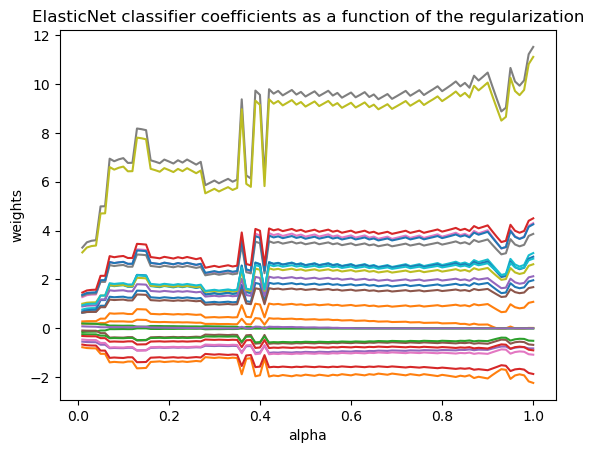

AUC on holdout test set 1.0


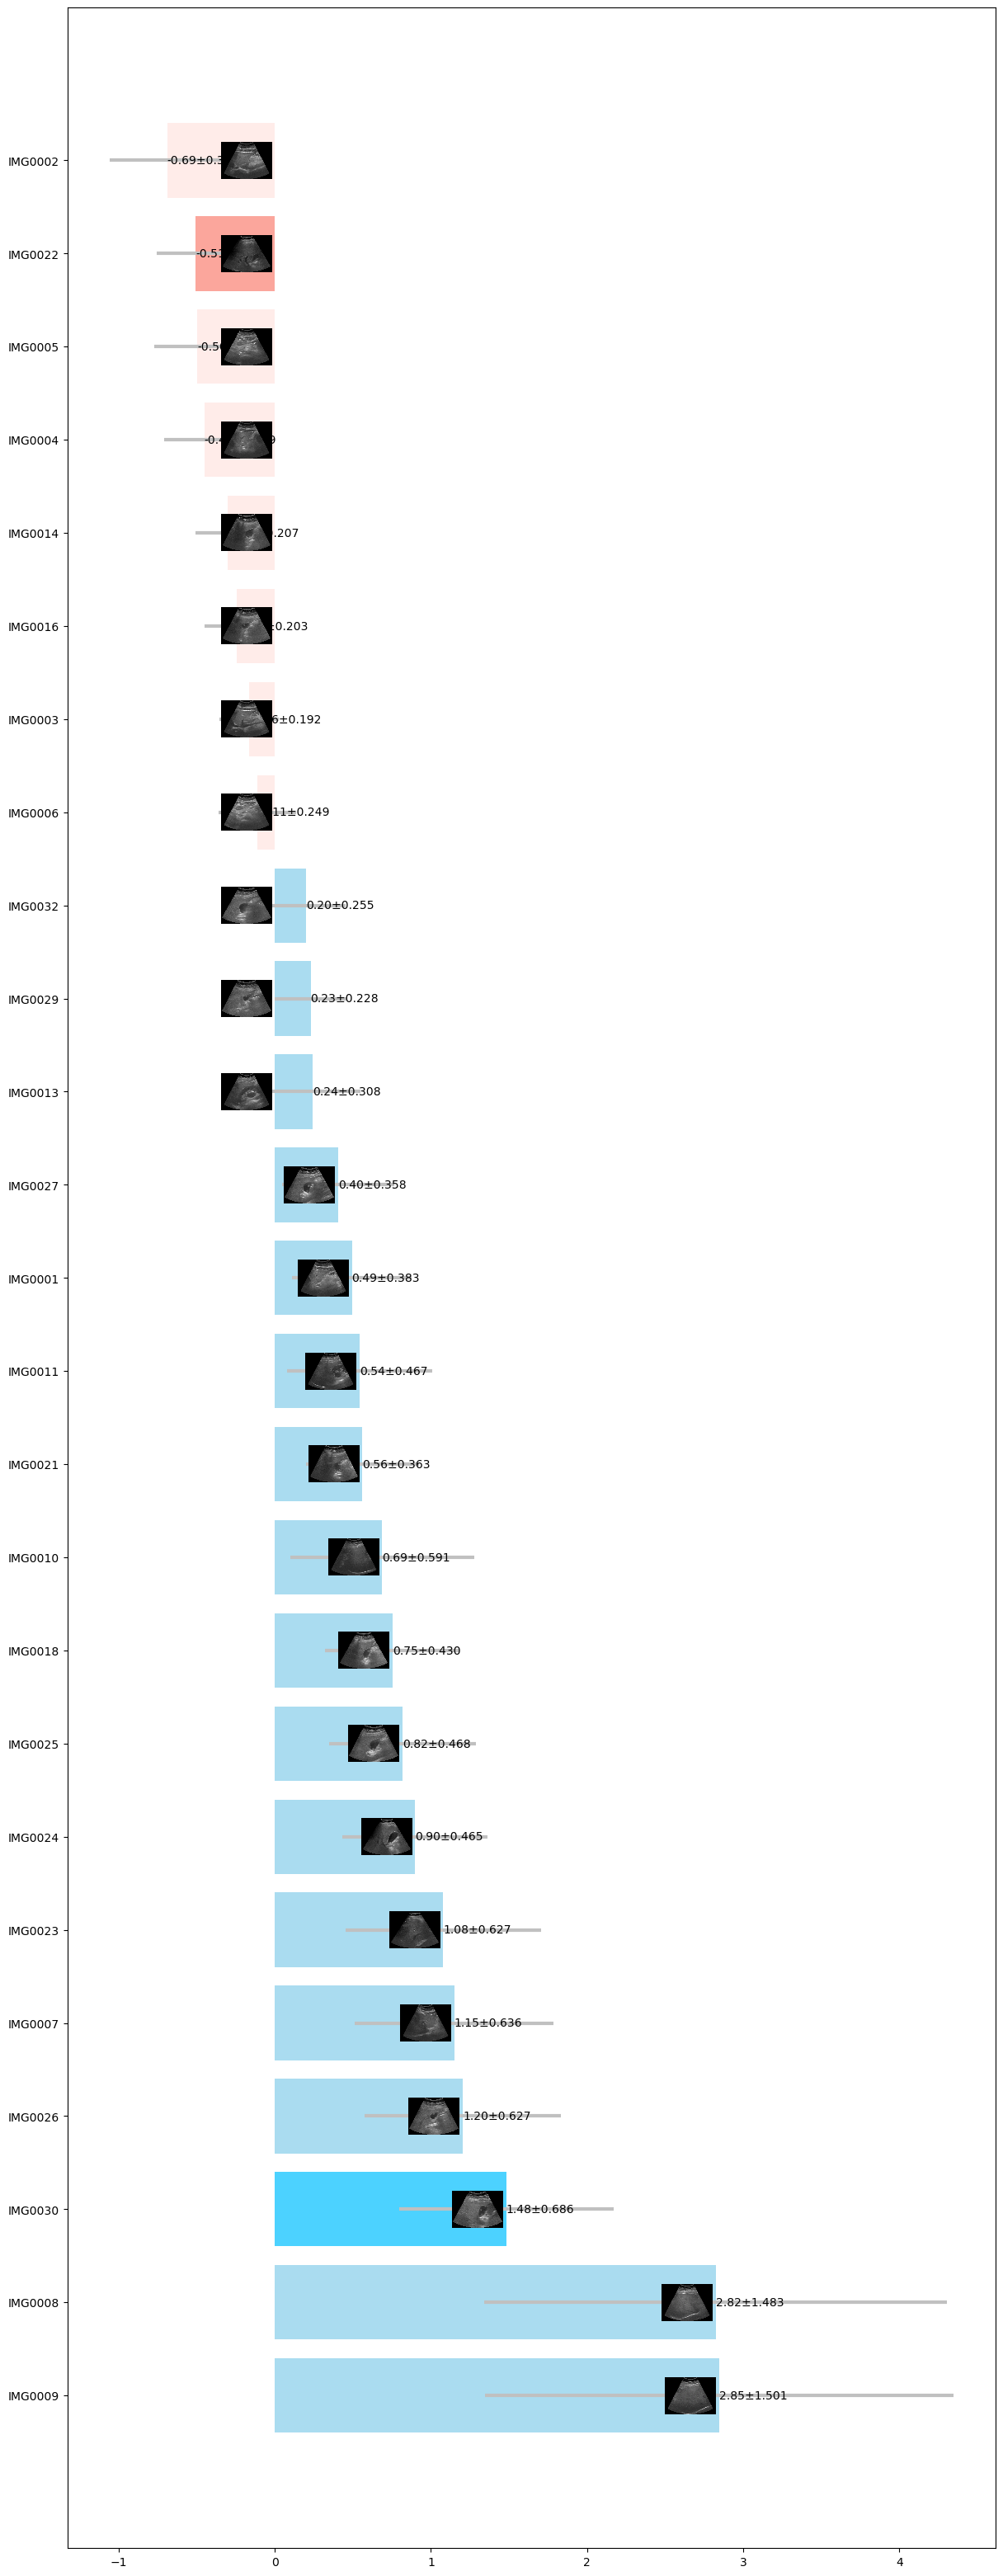

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/tjyen/anaconda3/envs/xai/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_138513/2450558256.py", line 14, in <module>
    model.plot_results(img_abs_filepaths.copy())
  File "/home/liuusa_tw/twbabd_image_xai_20062024/custom_elastic_net_classifier.py", line 364, in plot_results
NameError: name 'img_abs_filepah' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/tjyen/anaconda3/envs/xai/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2102, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/tjyen/anaconda3/envs/xai/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1310, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/home/tjyen/anaconda3/envs/xai/lib/python3.

<Figure size 640x480 with 0 Axes>

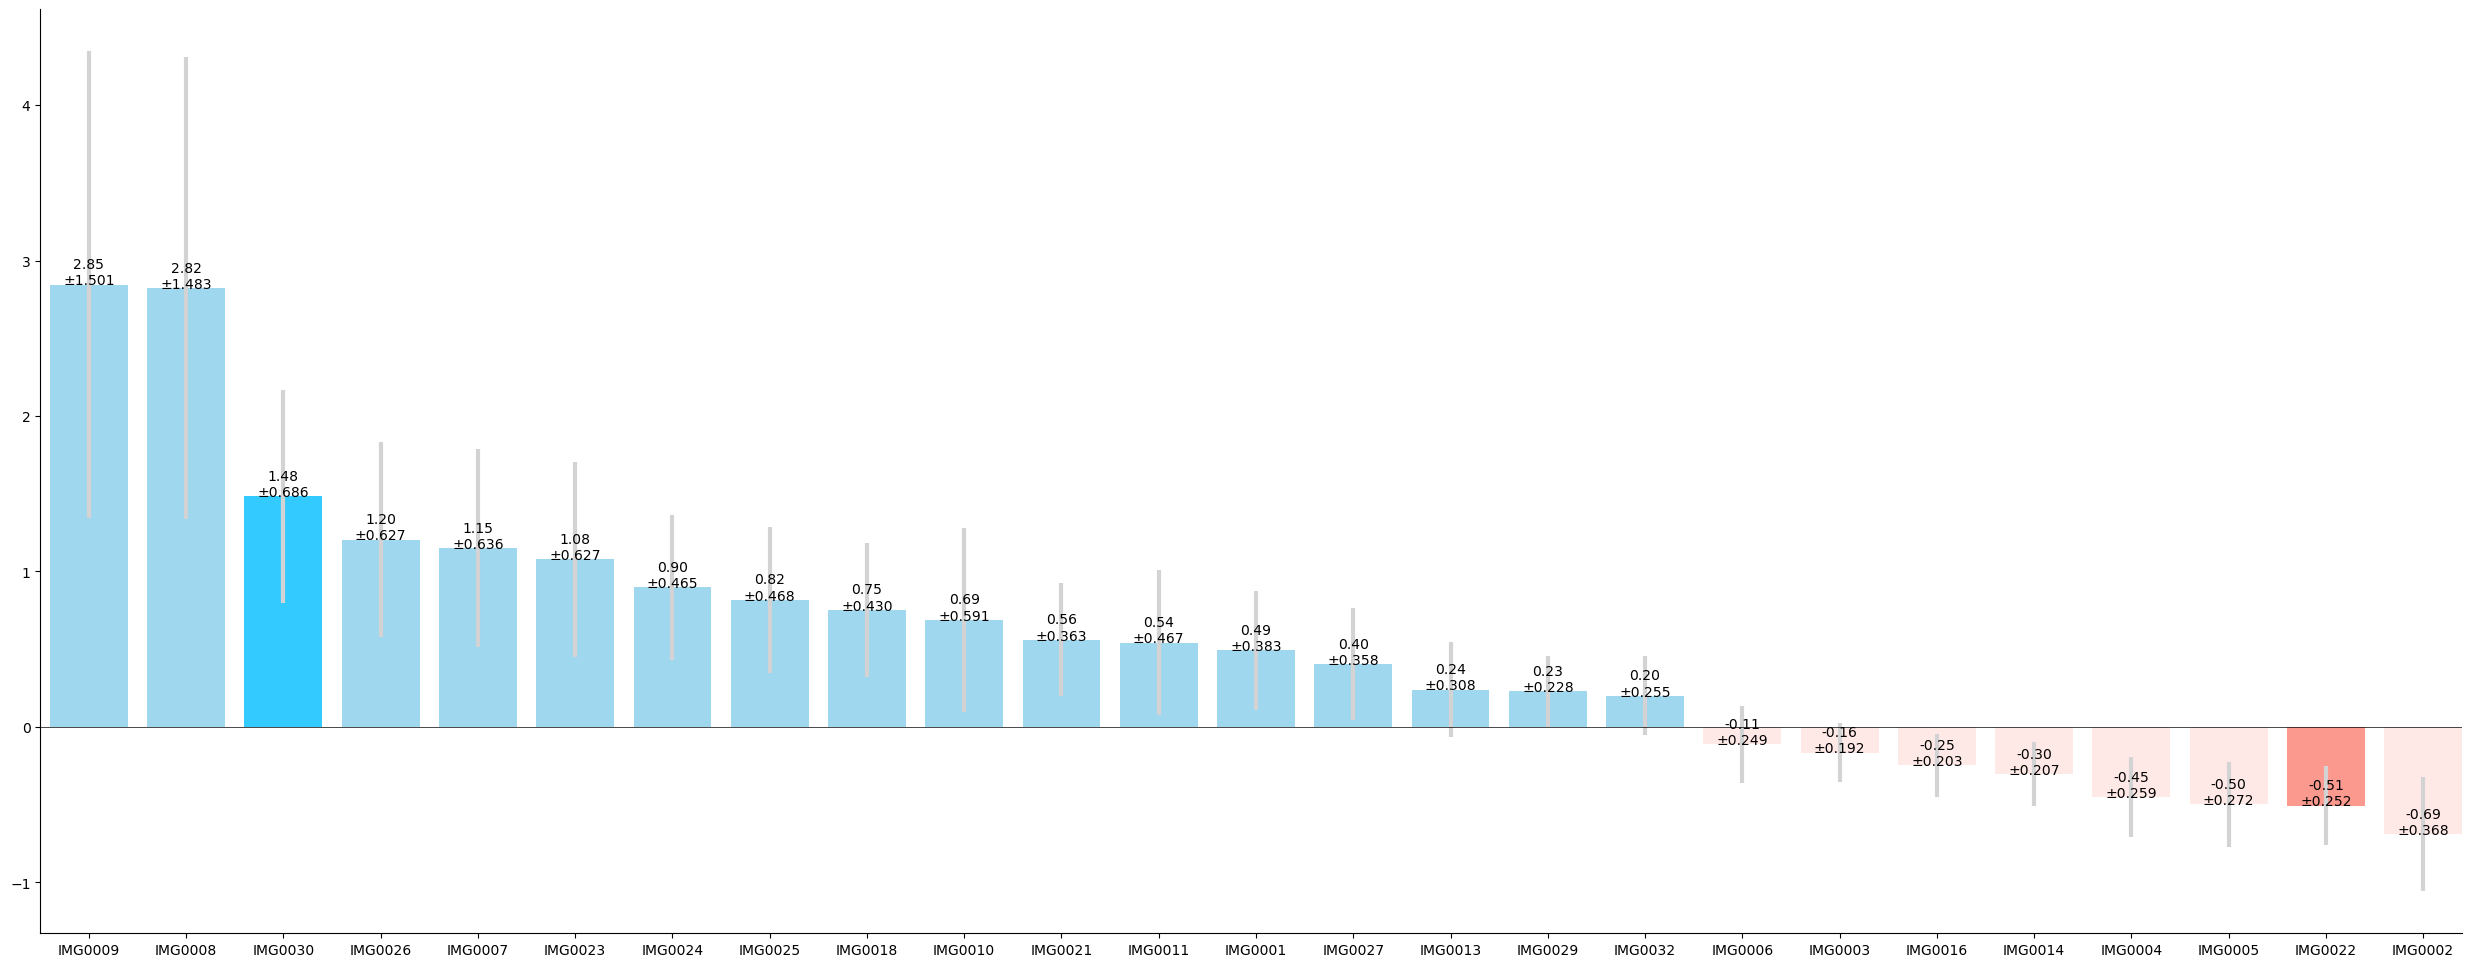

In [9]:

from classifiers import GLMNET_ElasticNetClassifierWithStats
# Fit model
model = GLMNET_ElasticNetClassifierWithStats(n_alphas=100, n_bootstrap_iterations=50)
model.fit(X_train, y_train)
model.visualize_alphas()

# Print summary
summary = model.summary()

# Calculate AUC on test set
y_pred_proba = model.predict_proba(X_test)
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC on holdout test set {auc}")
model.plot_results(img_abs_filepaths.copy())
summary

# Scikit-Learn ElasticNet Test

In [1]:
import ast
import pandas as pd 
import glob
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
from sklearn.metrics import silhouette_score
from dotenv import load_dotenv
import seaborn as sns
from usflc_xai import models, datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import datetime 
import gc
import numpy as np
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from joblib import Parallel, delayed
from classifiers import ElasticNetClassifierWithStats
import sys
load_dotenv()

CROP_IMAGE_DIR = os.getenv('CROP_IMAGE_DIR_PATH')
test_data_id = '09'
metadata_name = 'meta_data/TWB_ABD_expand_modified_gasex_21072022.csv'
test_data_list_name = 'fattyliver_2_class_certained_0_123_4_20_40_dataset_lists/dataset'+str(test_data_id)+'/test_dataset'+str(test_data_id)+'.csv'
test_data_list = pd.read_csv(test_data_list_name)
meta_data = pd.read_csv(metadata_name, sep=",")

image_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckpt_name = 'model_tl_twbabd'+str(test_data_id)+'/best_results.ckpt'
image_encoder_id = 'densenet121'
graph_encoder_id = 'SETNET_GAT'
num_classes = 2
input_dim = 1024
num_layers = 1
transform = transforms.Compose([
transforms.Grayscale(num_output_channels=3),
transforms.Resize([224, 224]),
transforms.ToTensor(),
transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

## Call pretrained image encoder ###
_, pretrained_image_encoder = models.image_encoder_model(name=image_encoder_id, 
                                        pretrained=True, 
                                        num_classes=num_classes, 
                                        device=device)
pretrained_image_encoder = pretrained_image_encoder.eval() 


# ## Subject id in the test data ##
# mi_id = test_data_list['MI_ID'][0]
# mi_id = "P0012750"
# ## Obtain image ids and label y for each subject. ###
# img_id_list = ast.literal_eval(meta_data[meta_data['MI_ID']==mi_id]['IMG_ID_LIST'].to_list()[0])
# print(mi_id, len(img_id_list), img_id_list)
# y = 1

ground_truth_pos_mi_ids = [mi_id
         for mi_id in test_data_list['MI_ID'] 
         if meta_data[meta_data['MI_ID']==mi_id]['liver_fatty'].to_list()[0]  > 0 ]
selected_mi_ids = [mi_id for mi_id in ground_truth_pos_mi_ids
                   if len(ast.literal_eval(meta_data[meta_data['MI_ID']==mi_id]['IMG_ID_LIST'].to_list()[0])) > 20
                   ]
selected_mi_ids = set(selected_mi_ids)
# selected_mi_ids = list(set(selected_mi_ids))
# print(len(ground_truth_pos_mi_ids), len(selected_mi_ids))


# img_id_list = ast.literal_eval(meta_data[meta_data['MI_ID']==mi_id]['IMG_ID_LIST'].to_list()[0])
# img_abs_filepaths = [CROP_IMAGE_DIR + str(mi_id) +'_'+str(i)+'.jpg' for i in img_id_list]
# assert(len(img_abs_filepaths) == len(img_id_list))
# assert(all(os.path.exists(i) for i in img_abs_filepaths))

def select_unique_columns(df):
    # Transpose the dataframe to compare columns
    df_t = df.T

    # Drop duplicate rows (which were originally columns)
    df_unique = df_t.drop_duplicates()
    
    # Transpose back to original orientation
    return df_unique.T

  0%|          | 0/1 [00:00<?, ?it/s]/home/tjyen/anaconda3/envs/xai/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tjyen/anaconda3/envs/xai/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tjyen/anaconda3/envs/xai/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tjyen/anaconda3/envs/xai/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tjyen/anaconda3/envs/xai/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings

Best ROC-AUC score:  1.0
Best C value:  21.54434690031882
Best L1 ratio:  0.3469387755102041
Intercept value:  1.4506472733438998
Boostrapping...
no adjustments
no adjustments
no adjustments
adjusting
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(454,)
[420 414 451 420 413 429 414 429]
no adjustments
no adjustments
no adjustments
adjusting
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(454,)
[426 451 451 421 451 429 424 451]
no adjustments
adjusting
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(454,)
[413 429 429 451 451 421 413 429]


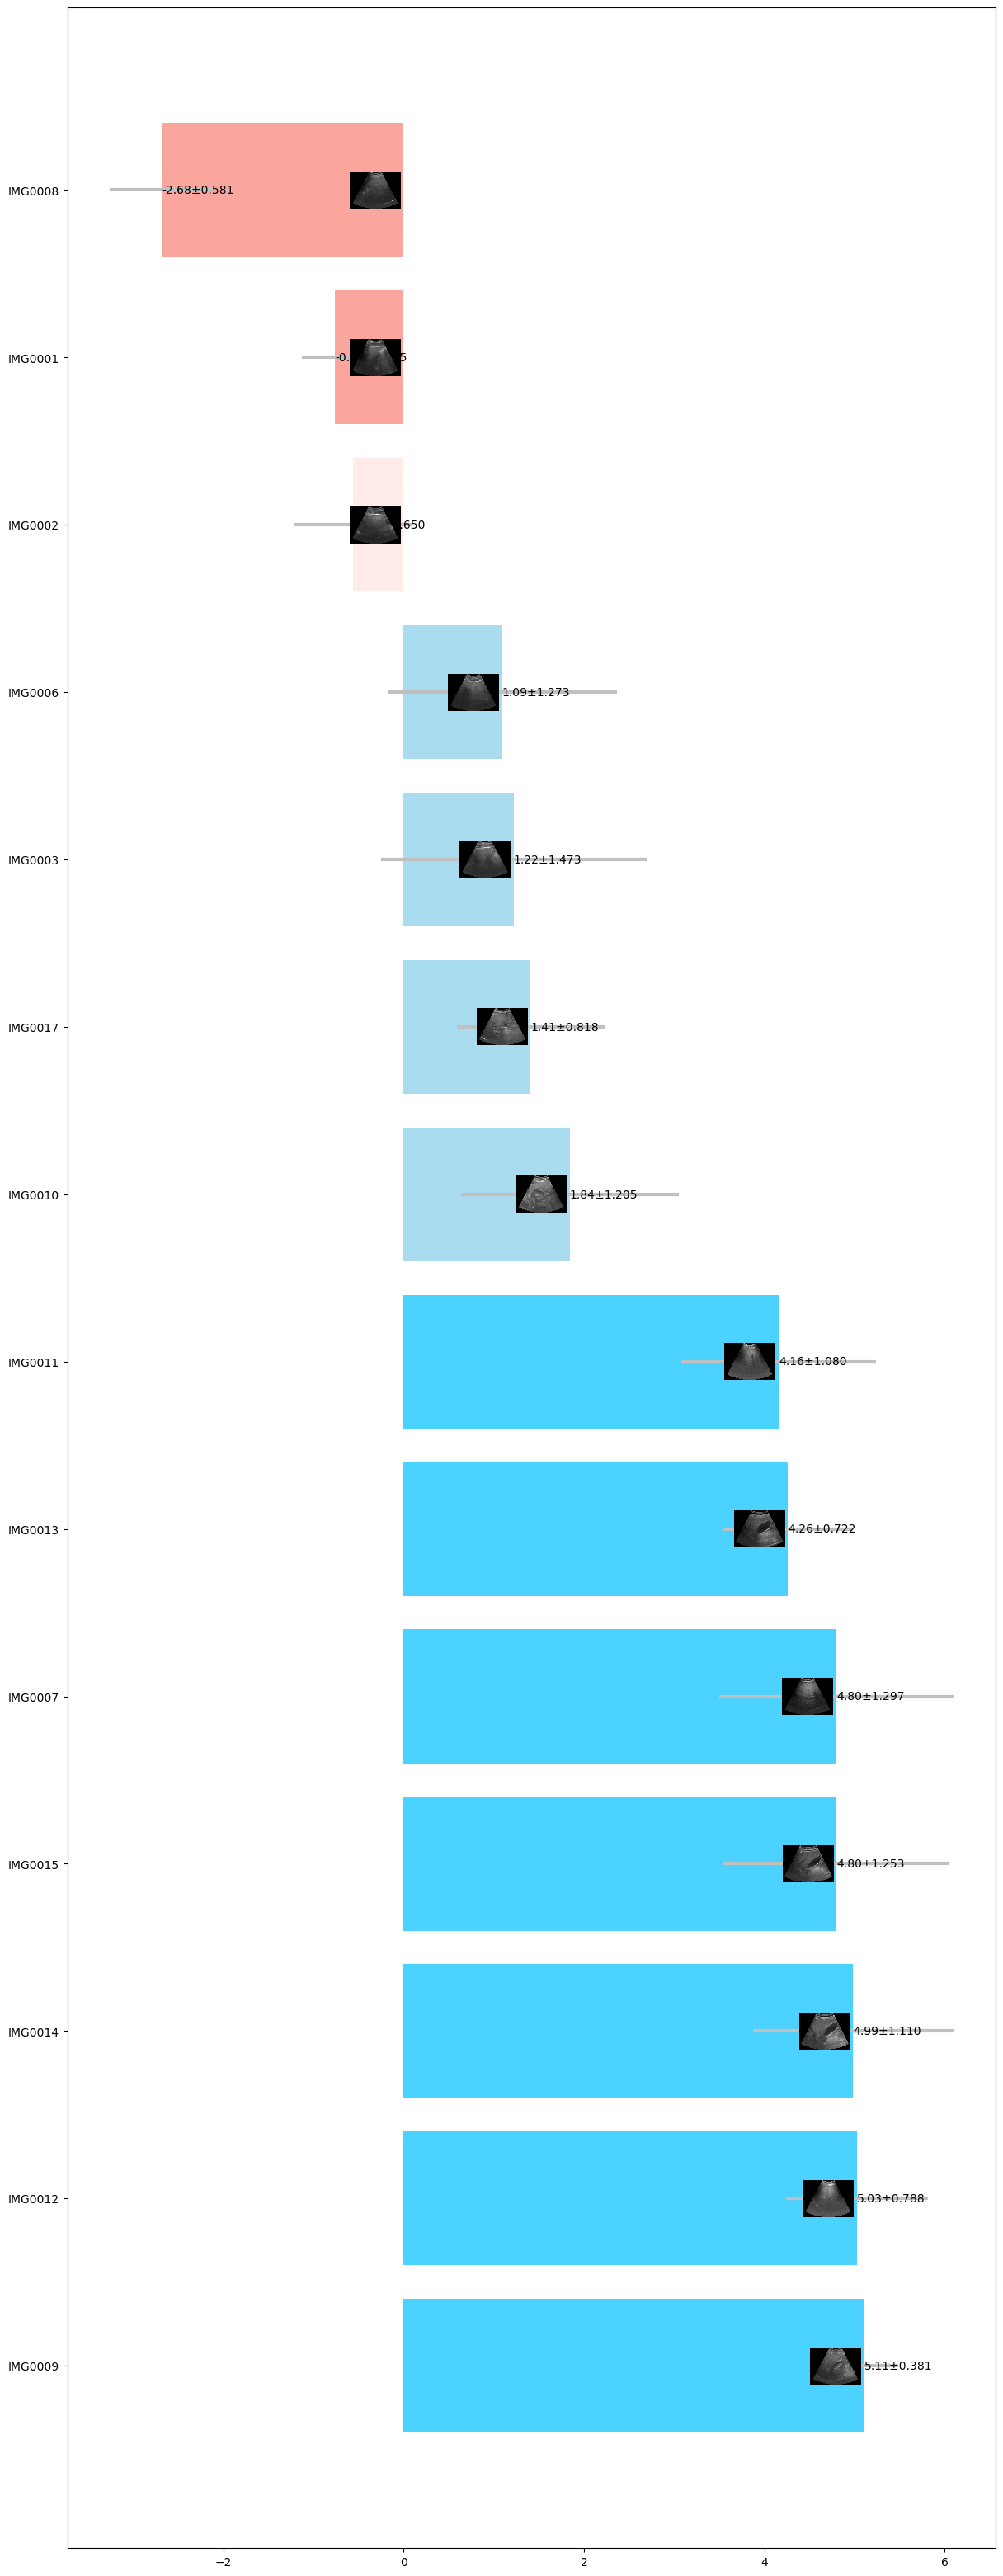

<Figure size 640x480 with 0 Axes>

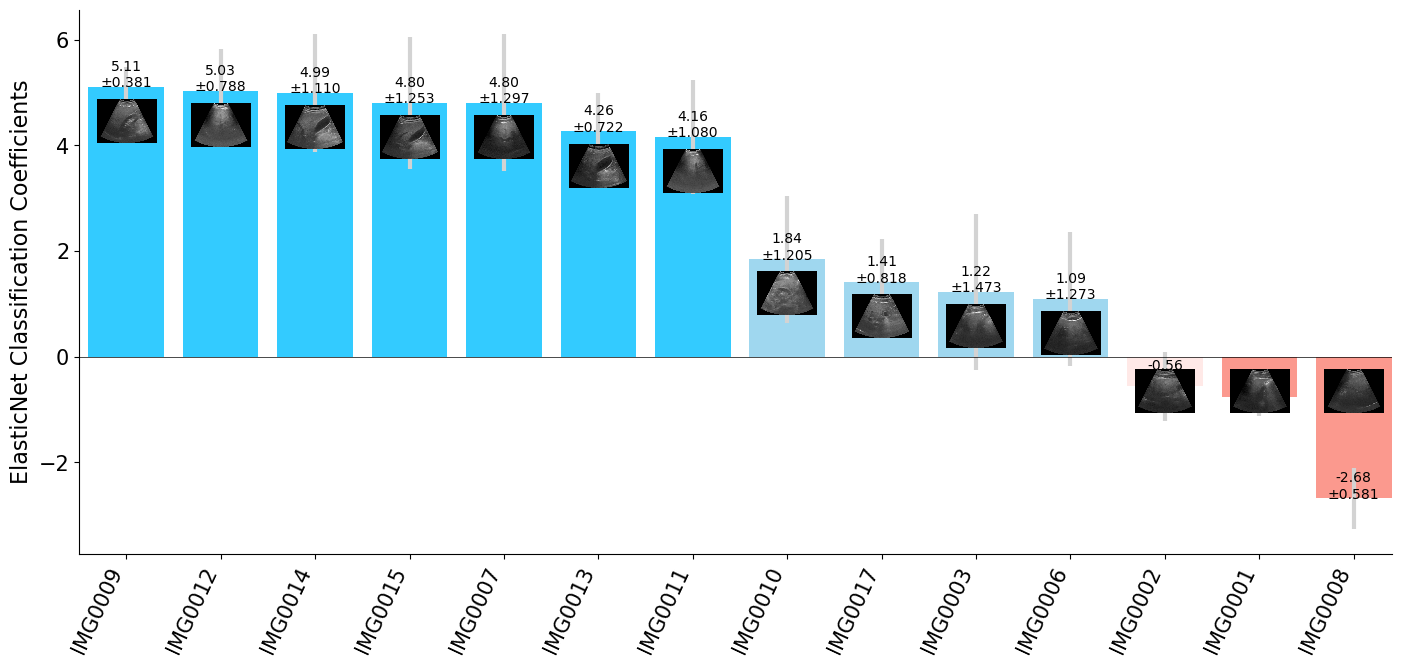

100%|██████████| 1/1 [00:34<00:00, 34.49s/it]

Results saved to /home/liuusa_tw/twbabd_image_xai_20062024/custom_lime_results/elastic-net-old-dataset-08-01-2024-01-59-27


<Figure size 640x480 with 0 Axes>

In [2]:
result_dir = "/home/liuusa_tw/twbabd_image_xai_20062024/custom_lime_results/07-12-2024-03-57-58/"
current_timestamp = datetime.datetime.now().strftime('%m-%d-%Y-%H-%M-%S')
all_subj_save_dir = os.path.join("/home/liuusa_tw/twbabd_image_xai_20062024/custom_lime_results",f"elastic-net-old-dataset-{current_timestamp}")
os.mkdir(all_subj_save_dir)
if result_dir.endswith("/"):
    csv_paths = glob.glob(result_dir+ "*/pred_results.csv")
else:
    csv_paths = glob.glob(result_dir+ "/*/pred_results.csv")
    
mi_ids = [i.split("/pred_results.csv")[0].split("/")[-1] for i in csv_paths]
df_dict = {mi_ids[i]: csv_paths[i] for i, _ in enumerate(mi_ids)}
df_dict = {k: pd.read_csv(v) for k, v in df_dict.items()}
df_dict = {k: v.drop_duplicates() for k, v in df_dict.items()}

miid_imgid_dict = {mi_id: ast.literal_eval(meta_data[meta_data['MI_ID']==mi_id]['IMG_ID_LIST'].to_list()[0]) 
                   for mi_id in mi_ids}

n_bootstrap_iterations = 10000

# img_abs_filepaths = {id: CROP_IMAGE_DIR + str(mi_id) +'_'+str(id)+'.jpg' for id in img_id_list}
# assert(len(img_abs_filepaths) == len(img_id_list))
# assert(all(os.path.exists(i) for i in img_abs_filepaths))
# print(img_id_list)

for i, (mi_id, df) in tqdm(enumerate(df_dict.items()), total = len(df_dict.keys())):
    if mi_id not in selected_mi_ids:
        continue
    if len(df['yhat'].unique()) < 2:
        print(f"{mi_id} was skipped because all y_hat were the same_values")
        continue
    
    # img_ids = miid_imgid_dict.get(mi_id)
    
    X_df = df.drop(['yhat', 'y'], axis=1).copy()
    X_df = select_unique_columns(X_df)
    y_df = df[['yhat']].copy()
    y_ = y_df.to_numpy().ravel()
    minority_class_size = min(y_df.value_counts())
    n_splits = min(minority_class_size, 10)

    img_filepaths = [os.path.join(CROP_IMAGE_DIR, f"{mi_id}_{img_id}.jpg") for img_id in X_df.columns]
    
    model = ElasticNetClassifierWithStats(n_l1_ratios=50, n_Cs= 10,max_iter = 1000,
                                          n_jobs = -1, n_bootstrap_iterations= n_bootstrap_iterations)
    model.fit(X_df, y_, n_splits = n_splits,)
    try: 
        model.fit(X_df, y_, n_splits = n_splits,)
    except ValueError as e:
        exc_type, _, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        print(e, exc_type, fname, exc_tb.tb_lineno)
        print(f"{mi_id} was skipped because ElasticNet is having some issues")
        continue

    save_dir = os.path.join(all_subj_save_dir, mi_id)
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    # Print summary
    summary = model.summary()
    summary.to_csv(os.path.join(save_dir, "elastic_net_coefficients.csv"),
                   index=None)

    model.plot_results(img_filepaths, save_dir=save_dir)
    
print(f"Results saved to {all_subj_save_dir}")

In [3]:
np.unique(y_)

array([0, 1])

In [7]:
values, counts = np.unique(y_, return_counts=True)
values, counts

(array([0, 1]), array([  8, 446]))

In [10]:
min_indx = np.argmin(counts)
min_val = values[min_indx]

In [11]:
np.min(counts)

8

In [29]:
np.unique(np.array(1))[0]

1

In [35]:
np.random.choice(np.where(y_ == 0)[0], 1)

array([414])

In [37]:
temp = np.random.choice(30, 30, replace=True)
print(temp)
removal = np.random.choice(temp, 1)

[18  3 24 28 25  6 29  6 27 29 14 15  3 15 21 10 19  0 24 28  0  9 24  2
 13 20 12 10 11 19]


array([29])